In [1]:
# Load Qiskit
from qiskit_ibm_runtime import QiskitRuntimeService, Batch
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv()
API_TOKEN = os.getenv("API_TOKEN")
API_INSTANCE = os.getenv("API_INSTANCE", None)
service = QiskitRuntimeService(channel="ibm_cloud", token=API_TOKEN, instance=API_INSTANCE)
backend = service.backend(name="ibm_rensselaer")

basis_gates = list(backend.operation_names)
print(basis_gates)

from IPython.display import display

import qiskit
from qiskit import transpile, QuantumCircuit

import numpy as np
import networkx as nx
from pprint import pprint

['ecr', 'reset', 'delay', 'switch_case', 'x', 'sx', 'rz', 'measure', 'id', 'if_else', 'for_loop']


In [2]:
# classical function

def xor(a: bool, b: bool) -> bool:
    return a ^ b

for a in [0, 1]:
    for b in [0, 1]:
        print(f"{a}{b} -> {int(xor(bool(a), bool(b)))}")

00 -> 0
01 -> 1
10 -> 1
11 -> 0


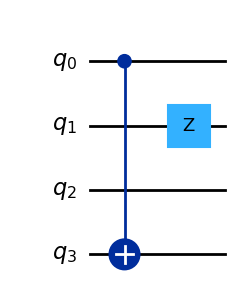

In [25]:
# Inputs: 0 1
# Target: 3
qc = QuantumCircuit(4)

# setup target qubit
# Computational oracle for x0
qc.cx(0, 3)

# phase oracle for x1
qc.z(1)

display(qc.draw('mpl'))

In [26]:
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import grover_operator

search_circuit = qiskit.QuantumCircuit(4, 2) # Classical bits for measuring N search qubits
search_circuit.h(range(3))
search_circuit.x(3)
search_circuit.h(3)
grover_op = grover_operator(qc, reflection_qubits=range(3), insert_barriers=True)
search_circuit.compose(grover_op, inplace=True)

search_circuit.h(3)
search_circuit.x(3)

sv = Statevector.from_instruction(search_circuit)
display(sv.draw('latex'))

for input in range(8):
    intput_bitstr = format(input, "04b")[::-1]
    sv = Statevector.from_int(input, 2**4)

    sv_out = sv.evolve(qc)
    print(sv.draw('latex_source'), "->", sv_out.draw('latex_source'))

<IPython.core.display.Latex object>

 |0000\rangle ->  |0000\rangle
 |0001\rangle ->  |1001\rangle
 |0010\rangle -> - |0010\rangle
 |0011\rangle -> - |1011\rangle
 |0100\rangle ->  |0100\rangle
 |0101\rangle ->  |1101\rangle
 |0110\rangle -> - |0110\rangle
 |0111\rangle -> - |1111\rangle



Running Grover with MANUAL Diffusion (N=2, Total Qubits=3)
Optimal iterations for N=2, M=2: 0


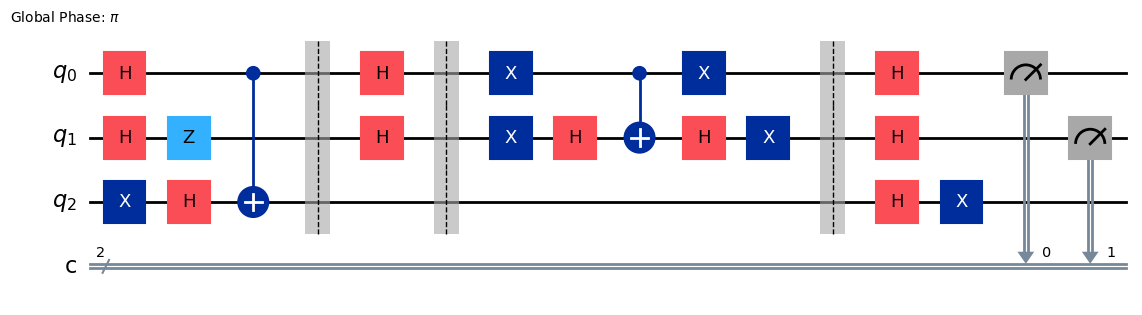

Running simulation...


{'11': 2549, '01': 2479, '10': 2498, '00': 2474}

In [22]:
import qiskit
from qiskit.quantum_info import Statevector
import numpy as np
import math
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import grover_operator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Assume analyze_counts function is defined as before
# from __main__ import analyze_counts

def find_solution_grover(oracle, num_vertex_qubits, m=1, use_simulator=False):
    """
    Grover's algorithm using a pre-constructed PHASE-FLIP oracle

    Args:
        oracle: The Qiskit QuantumCircuit implementing the phase-flip oracle.
        num_vertex_qubits: The number of qubits in the search space (N).
        m: The estimated number of solutions (default: 1).
        use_simulator: Flag to use AerSimulator.

    Returns:
        A dictionary of measurement counts.
    """
    n = num_vertex_qubits
    if n < 1:
        print("Warning: Number of search qubits must be at least 1.")
        return {}
    total_qubits = oracle.num_qubits
    print(f"\nRunning Grover with MANUAL Diffusion (N={n}, Total Qubits={total_qubits})")

    # Ensure oracle has enough qubits for the search space
    if total_qubits < n:
         raise ValueError(f"Oracle qubit count ({total_qubits}) is less than search space ({n}).")

    # ---  Calculate Iterations ---
    if not (m >= 1 and m <= 2**n):
         print(f"Warning: Number of solutions m={m} is outside valid range [1, 2^N]. Assuming m=1.")
         m = 1

    optimal_iterations = 0
    if m < (1 << n): # Avoid error if m=2^n
        optimal_iterations = math.floor(
            math.pi / (4 * math.asin(math.sqrt(m / (1 << n))))
        )
    print(f"Optimal iterations for N={n}, M={m}: {optimal_iterations}")

    if optimal_iterations == 0 and m > 0:
        print("Warning: Optimal iterations calculated as 0. Grover search may not be effective.")
        # Still run once if you want to see oracle effect
        # optimal_iterations = 1

        
    simulator = AerSimulator()

    search_circuit = qiskit.QuantumCircuit(total_qubits, n) # Classical bits for measuring N search qubits
    search_circuit.h(range(n))
    search_circuit.x(2)
    search_circuit.h(2)
    grover_op = grover_operator(oracle, reflection_qubits=range(n), insert_barriers=True)
    search_circuit.compose(grover_op, inplace=True)

    search_circuit.h(2)
    search_circuit.x(2)
    search_circuit.measure(range(n), range(n))
    display(search_circuit.draw('mpl'))

    # ---  Run Simulation ---
    
    # Transpilation is likely needed because mcx might decompose further
    qc = transpile(search_circuit, simulator)
    print("Running simulation...")
    result = simulator.run(qc, shots=10**4).result()
    counts = result.get_counts()

    return counts

sim_counts = find_solution_grover(
    oracle=qc,
    num_vertex_qubits=2,
    m=2,
)

sim_counts